# Data analysis

In [2]:
import pandas as pd
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from Bio import pairwise2
from Bio.Seq import Seq
from tqdm import tqdm
import subprocess
import os
import shutil
import glob
import sys

import os
os.chdir('/home/ku76797/Documents/internship/Work/CATHe')

/home/ku76797/Documents/internship/Work/CATHe/myenv_2/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
df_train = pd.read_csv('../data/Dataset/csv/Train.csv')
# Extract Super Families (SF column) 
y_train = df_train['SF'].tolist()
# Extract AA Sequences
AA_sequences_train = df_train['Sequence'].tolist()


# val

df_val = pd.read_csv('../data/Dataset/csv/Val.csv')
# Extract Super Families (SF column)
y_val = df_val['SF'].tolist()
# Extract AA Sequences
AA_sequences_val = df_val['Sequence'].tolist()


# test

df_test = pd.read_csv('../data/Dataset/csv/Test.csv')
# Extract Super Families (SF column)
y_test = df_test['SF'].tolist()
# Extract AA Sequences
AA_sequences_test = df_test['Sequence'].tolist()

dataset import

## 1. AA sequences

### 1.1 AA type statistics

In [3]:
def count_amino_acids(sequence_list):
    # Initialize a Counter
    aa_counter = Counter()
    
    # Iterate through each sequence and update the counter
    for sequence in sequence_list:
        aa_counter.update(sequence)
    
    return aa_counter

def print_amino_acid_proportions(aa_count, dataset_name):
    total_aa = sum(aa_count.values())
    print(f"\n{dataset_name} Amino Acid Counts and Proportions:")
    for aa, count in aa_count.items():
        proportion = count / total_aa
        print(f"{aa}: {count} ({proportion:.2%})")

# Count amino acids in each dataset
train_aa_count = count_amino_acids(AA_sequences_train)
val_aa_count = count_amino_acids(AA_sequences_val)
test_aa_count = count_amino_acids(AA_sequences_test)

# Print results
print_amino_acid_proportions(train_aa_count, "Train")
print_amino_acid_proportions(val_aa_count, "Validation")
print_amino_acid_proportions(test_aa_count, "Test")




Train Amino Acid Counts and Proportions:
N: 4636984 (4.48%)
A: 9233029 (8.92%)
Y: 3329127 (3.21%)
Q: 4039084 (3.90%)
H: 2348145 (2.27%)
G: 6696319 (6.47%)
T: 5816165 (5.62%)
P: 4089910 (3.95%)
L: 10519497 (10.16%)
M: 1999872 (1.93%)
D: 5980986 (5.78%)
W: 1280859 (1.24%)
K: 5500377 (5.31%)
V: 6846672 (6.61%)
S: 7298022 (7.05%)
E: 6567647 (6.34%)
I: 6031510 (5.82%)
F: 4009142 (3.87%)
R: 5806675 (5.61%)
C: 1482549 (1.43%)
X: 41182 (0.04%)
B: 18 (0.00%)
U: 12 (0.00%)
O: 2 (0.00%)
Z: 9 (0.00%)

Validation Amino Acid Counts and Proportions:
Y: 33727 (3.41%)
Q: 37967 (3.84%)
S: 60798 (6.15%)
L: 95020 (9.60%)
M: 15875 (1.60%)
V: 69121 (6.99%)
G: 69264 (7.00%)
H: 25794 (2.61%)
A: 79710 (8.06%)
P: 43391 (4.39%)
E: 68844 (6.96%)
D: 57563 (5.82%)
T: 52974 (5.35%)
F: 39104 (3.95%)
I: 56368 (5.70%)
N: 41522 (4.20%)
R: 52205 (5.28%)
K: 57643 (5.83%)
X: 6643 (0.67%)
W: 13321 (1.35%)
C: 12520 (1.27%)

Test Amino Acid Counts and Proportions:
Y: 33637 (3.40%)
R: 51535 (5.22%)
E: 69481 (7.03%)
L: 94576 (

### 1.2 AA sequence length statistics

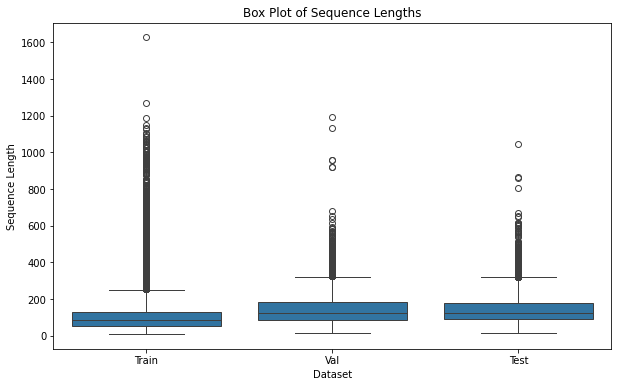

In [4]:
# Calculate sequence lengths
train_lengths = [len(seq) for seq in AA_sequences_train]
val_lengths = [len(seq) for seq in AA_sequences_val]
test_lengths = [len(seq) for seq in AA_sequences_test]

# Prepare data for plotting
data = pd.DataFrame({
    'Length': train_lengths + val_lengths + test_lengths,
    'Dataset': ['Train'] * len(train_lengths) + ['Val'] * len(val_lengths) + ['Test'] * len(test_lengths)
})

# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dataset', y='Length', data=data)
plt.title('Box Plot of Sequence Lengths')
plt.xlabel('Dataset')
plt.ylabel('Sequence Length')
plt.show()

In [5]:

# Calculate the shortest and longest sequences in each dataset
train_shortest = min(train_lengths)
train_longest = max(train_lengths)
val_shortest = min(val_lengths)
val_longest = max(val_lengths)
test_shortest = min(test_lengths)
test_longest = max(test_lengths)

# Print results
print("\nSequence Lengths:")
print(f"Train: Shortest={train_shortest}, Longest={train_longest}")
print(f"Validation: Shortest={val_shortest}, Longest={val_longest}")
print(f"Test: Shortest={test_shortest}, Longest={test_longest}")



Sequence Lengths:
Train: Shortest=10, Longest=1627
Validation: Shortest=14, Longest=1192
Test: Shortest=13, Longest=1047


### 1.3 AA transition matrix

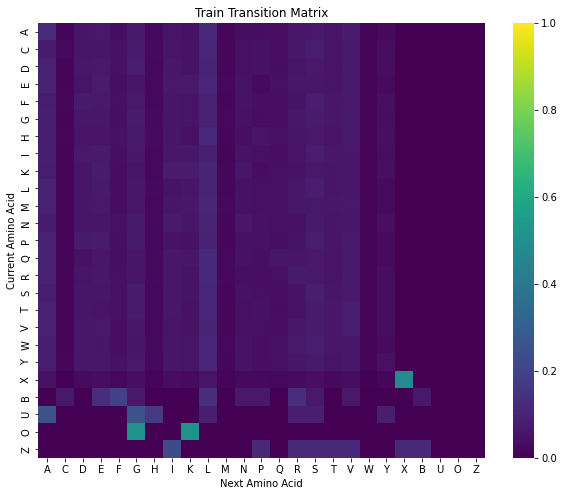

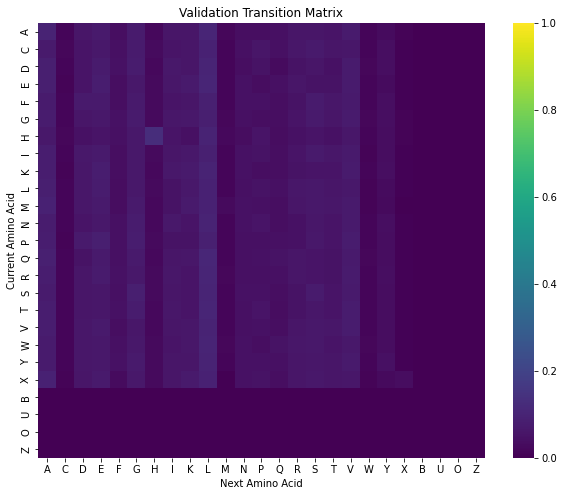

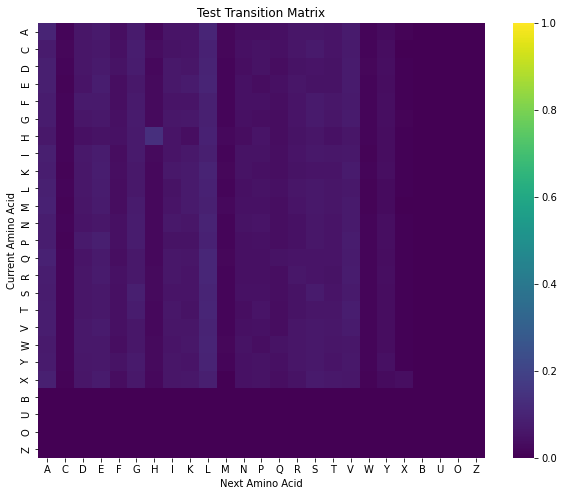

In [6]:
amino_acids = 'ACDEFGHIKLMNPQRSTVWYXBUOZ'

def calculate_transition_matrix(sequence_list):
    # Initialize a transition matrix
    transition_matrix = np.zeros((len(amino_acids), len(amino_acids)))
    
    # Set to store unknown amino acids
    unknown_amino_acids = set()
    
    # Iterate through each sequence and update the transition matrix
    for sequence in sequence_list:
        for i in range(len(sequence) - 1):
            # Get the current and next amino acids
            current_aa = sequence[i]
            next_aa = sequence[i + 1]
            
            if current_aa not in amino_acids:
                unknown_amino_acids.add(current_aa)
                continue
            if next_aa not in amino_acids:
                unknown_amino_acids.add(next_aa)
                continue
            
            # Update the transition matrix
            current_idx = amino_acids.index(current_aa)
            next_idx = amino_acids.index(next_aa)
            transition_matrix[current_idx, next_idx] += 1
    
    # Print unknown amino acids
    if unknown_amino_acids:
        print(f"Unknown amino acids found: {', '.join(unknown_amino_acids)}")
    
    # Normalize the transition matrix
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(transition_matrix, row_sums, where=row_sums != 0)

    # Set rows with zero sums to zero
    transition_matrix[row_sums.flatten() == 0] = 0
    
    return transition_matrix

def plot_transition_matrix(transition_matrix, title):
    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix, cmap='viridis', xticklabels=list(amino_acids), yticklabels=list(amino_acids), vmin=0, vmax=1)
    plt.title(title)
    plt.xlabel('Next Amino Acid')
    plt.ylabel('Current Amino Acid')
    plt.show()

# Calculate transition matrices for each dataset
train_transition_matrix = calculate_transition_matrix(AA_sequences_train)
val_transition_matrix = calculate_transition_matrix(AA_sequences_val)
test_transition_matrix = calculate_transition_matrix(AA_sequences_test)

# Plot transition matrices
plot_transition_matrix(train_transition_matrix, 'Train Transition Matrix')
plot_transition_matrix(val_transition_matrix, 'Validation Transition Matrix')
plot_transition_matrix(test_transition_matrix, 'Test Transition Matrix')


## 2. CATH categories

In [7]:
# count the number of unique super families in each dataset
train_sf_count = len(set(y_train))
val_sf_count = len(set(y_val))
test_sf_count = len(set(y_test))

# Print results
print("\nNumber of Unique Super Families:")
print(f"Train: {train_sf_count}")
print(f"Validation: {val_sf_count}")
print(f"Test: {test_sf_count}")




Number of Unique Super Families:
Train: 1772
Validation: 1772
Test: 1772


Top 5 Super Families in Train:
1.25.40.10: 5.69%
3.40.50.300: 2.70%
2.60.40.10: 2.54%
2.130.10.10: 2.49%
3.80.10.10: 2.23%


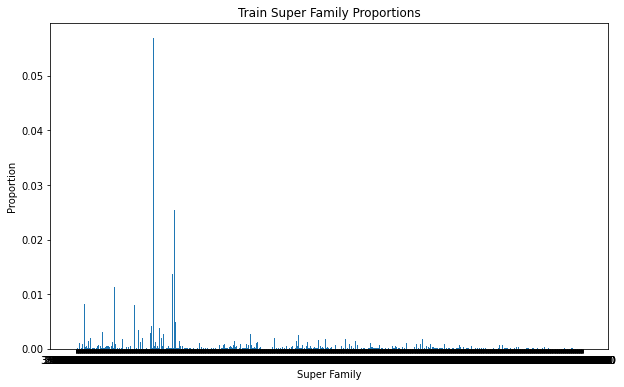

Top 5 Super Families in Validation:
2.60.40.10: 2.86%
1.10.10.10: 2.34%
3.40.50.300: 1.79%
3.40.50.720: 1.39%
3.40.190.10: 1.33%


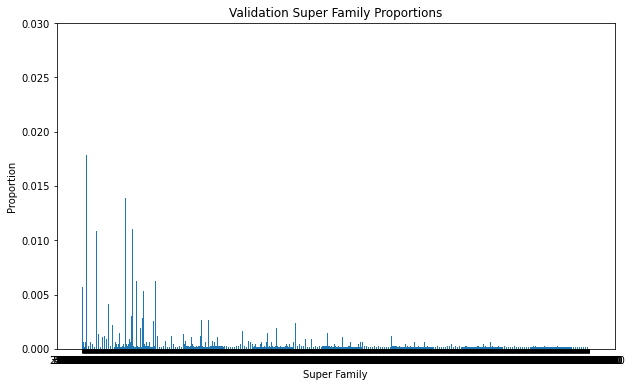

Top 5 Super Families in Test:
2.60.40.10: 2.86%
1.10.10.10: 2.34%
3.40.50.300: 1.80%
3.40.50.720: 1.39%
3.40.190.10: 1.34%


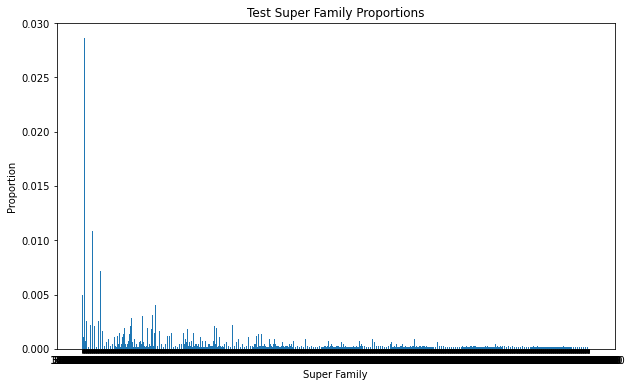

In [8]:
# Plot one a graph the proportion of each super family in each dataset
def plot_sf_proportions(y, dataset_name):
    # Count the number of sequences in each super family
    sf_counter = Counter(y)
    
    # Calculate proportions
    total_sf = sum(sf_counter.values())
    proportions = {sf: count / total_sf for sf, count in sf_counter.items()}

    # Sort super families by proportion
    sorted_sf = sorted(proportions.items(), key=lambda item: item[1], reverse=True)
    
    # Get top 5 super families
    top_5_sf = sorted_sf[:5]
    top_5_sf_names = [sf for sf, _ in top_5_sf]
    top_5_sf_proportions = [proportions[sf] for sf in top_5_sf_names]
    
    # Print the top 5 super families and their proportions
    print(f'Top 5 Super Families in {dataset_name}:')
    for sf, proportion in top_5_sf:
        print(f'{sf}: {proportion:.2%}')
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(proportions.keys(), proportions.values())
    plt.title(f'{dataset_name} Super Family Proportions')
    plt.xlabel('Super Family')
    plt.ylabel('Proportion')
    plt.show()

# Plot super family proportions
plot_sf_proportions(y_train, 'Train')
plot_sf_proportions(y_val, 'Validation')
plot_sf_proportions(y_test, 'Test')






## 2. Sequence identity

### 2.1 Sequence identity inside dataset

#### 2.1.1 Sequence identity inside Test dataset

the next cell is for generating the alignment results, if the result files are already there, no need to run the code in this cell

In [10]:
# with open('sequences.fasta', 'w') as f:
#    for i, seq in enumerate(AA_sequences_test):
#        f.write(f">seq{i}\n{seq}\n")

# Write this in terminal 

#Create database 
# mmseqs createdb sequences.fasta sequencesDB

# # Perform search
# mmseqs search sequencesDB sequencesDB resultDB tmp --threads 8

# # Convert results to a tabular format
# mmseqs convertalis sequencesDB sequencesDB resultDB result_test.m8 --format-output "query,target,pident"

In [12]:



# Read the MMseqs2 output
df_results = pd.read_csv('result_test.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Remove self-alignments
df_results = df_results[df_results['query'] != df_results['subject']]

# Get minimal identity
max_identity = df_results['identity'].max()
print(f'Max sequence identity, Test set: {max_identity:.2f}%')

# Delete all created files exept "result_test.m8"



Max sequence identity: 100.00%


#### 2.1.2 Sequence identity inside Validation dataset

the next cell is for generating the alignment results, if the result files are already there, no need to run the code in this cell

In [13]:
# with open('sequences.fasta', 'w') as f:
#    for i, seq in enumerate(AA_sequences_val):
#        f.write(f">seq{i}\n{seq}\n")

# Write this in terminal 

#Create database 
# mmseqs createdb sequences.fasta sequencesDB

# # Perform search
# mmseqs search sequencesDB sequencesDB resultDB tmp --threads 8

# # Convert results to a tabular format
# mmseqs convertalis sequencesDB sequencesDB resultDB result_val.m8 --format-output "query,target,pident"

In [14]:
# Read the MMseqs2 output
df_results = pd.read_csv('result_val.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Remove self-alignments
df_results = df_results[df_results['query'] != df_results['subject']]

# Get minimal identity
max_identity = df_results['identity'].max()
print(f'Max sequence identity, Validation set: {max_identity:.2f}%')

# Delete all created files exept "result_val.m8"

Max sequence identity, Validation set: 100.00%


#### 2.1.3 Sequence identity inside Training dataset

the next cell is for generating the alignment results, if the result files are already there, no need to run the code in this cell

In [15]:
# with open('sequences.fasta', 'w') as f:
#    for i, seq in enumerate(AA_sequences_train):
#        f.write(f">seq{i}\n{seq}\n")


# Write this in terminal 

#Create database 
# mmseqs createdb sequences.fasta sequencesDB

# # Perform search
# mmseqs search sequencesDB sequencesDB resultDB tmp --threads 8

# # Convert results to a tabular format
# mmseqs convertalis sequencesDB sequencesDB resultDB result_train.m8 --format-output "query,target,pident"

In [17]:
# Read the MMseqs2 output
df_results = pd.read_csv('result_train.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Remove self-alignments
df_results = df_results[df_results['query'] != df_results['subject']]

# Get minimal identity
max_identity = df_results['identity'].max()
print(f'Max sequence identity, Training set: {max_identity:.2f}%')

# Delete all created files exept "result_train.m8"

Max sequence identity, Training set: 100.00%


Print the similar sequences

In [18]:
# Create a pandas Series from the sequences
sequences_series = pd.Series(AA_sequences_train)

# Find duplicate sequences
duplicates = sequences_series[sequences_series.duplicated(keep=False)]

# Print results
if not duplicates.empty:
    print(f"There are {len(duplicates)} duplicate sequences in the dataset.")
    print("Here are the duplicate sequences:")
    print(duplicates)
else:
    print("There are no duplicate sequences in the dataset.")


There are 433 duplicate sequences in the dataset.
Here are the duplicate sequences:
592           KIKLLFQTGF
668          IDRRGFTIHWI
1695        TRALNVSSYNYL
1709       TTKVLNFGSYNYL
1710        TRALNISSYNYL
               ...      
1006343       LGILVRSKDT
1014484       VIFDMDGVMI
1014485       VIFDMDGVMI
1018354    TTKVLNFGSYNYL
1023005       LGILVRTRDT
Length: 433, dtype: object


### 2.2 Sequence identity between datasets

#### 2.2.1 Sequence identity between test and val

In [ ]:
# with open('sequences_val.fasta', 'w') as f:
#     for i, seq in enumerate(AA_sequences_val):
#         f.write(f">val_seq{i}\n{seq}\n")

# with open('sequences_test.fasta', 'w') as f:
#     for i, seq in enumerate(AA_sequences_test):
#         f.write(f">test_seq{i}\n{seq}\n")

# # Step 2: Run MMseqs2 commands
# # Create databases
# subprocess.run(["mmseqs", "createdb", "sequences_val.fasta", "valDB"])
# subprocess.run(["mmseqs", "createdb", "sequences_test.fasta", "testDB"])

# # Perform search (validation set against test set)
# subprocess.run(["mmseqs", "search", "valDB", "testDB", "resultDB", "tmp", "--threads", "8"])

# # Convert results to a tabular format
# subprocess.run(["mmseqs", "convertalis", "valDB", "testDB", "resultDB", "result_val_vs_test.m8", "--format-output", "query,target,pident"])

In [14]:
# Step 3: Parse the MMseqs2 output
df_results = pd.read_csv('result_val_vs_test.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Get maximum identity
max_identity = df_results['identity'].max()
print(f'Maximum sequence identity between Validation and Test sets: {max_identity:.2f}%')


Maximum sequence identity between Validation and Test sets: 100.00%


In [ ]:
# # Step 4: Delete all created files except for the result file ()
# files_to_delete = ['sequences_val.fasta', 'sequences_test.fasta', 'valDB', 'testDB', 'resultDB', 'tmp']
# for file in files_to_delete:
#     for path in glob.glob(file + '*'):
#         try:
#             if os.path.isdir(path):
#                 shutil.rmtree(path)
#             else:
#                 os.remove(path)
#         except Exception as e:
#             print(f"Error deleting {path}: {e}")

#### 2.2.2 Sequence identity between train and test 

In [19]:
with open('sequences_train.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_train):
        f.write(f">train_seq{i}\n{seq}\n")

with open('sequences_test.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_test):
        f.write(f">test_seq{i}\n{seq}\n")

# # Create databases
# mmseqs createdb sequences_train.fasta trainDB
# mmseqs createdb sequences_test.fasta testDB

# # Perform search (training set against test set)
# mmseqs search trainDB testDB resultDB_train_vs_test tmp_train_vs_test --threads 8

# # Convert results to a tabular format
# mmseqs convertalis trainDB testDB resultDB_train_vs_test result_train_vs_test.m8 --format-output query,target,pident


In [17]:
# Step 3: Parse the MMseqs2 output
df_results = pd.read_csv('result_train_vs_test.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Get maximum identity
max_identity = df_results['identity'].max()
print(f'Maximum sequence identity between Training and Test sets: {max_identity:.2f}%')

# Step 4: Delete all created files except for the result file
files_to_delete = ['sequences_train.fasta', 'sequences_test.fasta', 'trainDB', 'testDB', 'resultDB_train_vs_test', 'tmp_train_vs_test']
for file in files_to_delete:
    for path in glob.glob(file + '*'):
        try:
            if os.path.isdir(path):
                shutil.rmtree(path)
            else:
                os.remove(path)
        except Exception as e:
            print(f"Error deleting {path}: {e}")

Maximum sequence identity between Training and Test sets: 100.00%


inversing the query and the subject datasets for identity check


In [25]:
# Step 1: Create FASTA files for test and training sets
with open('sequences_test.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_test):
        f.write(f">test_seq{i}\n{seq}\n")

with open('sequences_train.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_train):
        f.write(f">train_seq{i}\n{seq}\n")

# # Create databases
# mmseqs createdb sequences_test.fasta testDB
# mmseqs createdb sequences_train.fasta trainDB

# # Perform search (test set against training set)
# mmseqs search testDB trainDB resultDB_test_vs_train tmp_test_vs_train --threads 8

# # Convert results to a tabular format
# mmseqs convertalis testDB trainDB resultDB_test_vs_train result_test_vs_train.m8 --format-output query,target,pident

In [26]:
# Step 3: Parse the MMseqs2 output
df_results = pd.read_csv('result_test_vs_train.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Get maximum identity
max_identity = df_results['identity'].max()
print(f'Maximum sequence identity between Test and Training sets: {max_identity:.2f}%')

# Step 4: Delete all created files except for the result file
files_to_delete = [
    'sequences_test.fasta', 'sequences_train.fasta',
    'testDB', 'trainDB', 'resultDB_test_vs_train', 'tmp_test_vs_train',
    'testDB_h', 'trainDB_h', 'resultDB_test_vs_train_h'
]
for file in files_to_delete:
    for path in glob.glob(file + '*'):
        try:
            if os.path.isdir(path):
                shutil.rmtree(path)
            else:
                os.remove(path)
        except Exception as e:
            print(f"Error deleting {path}: {e}")


Maximum sequence identity between Test and Training sets: 84.10%


Print the similar sequences from train to test

In [22]:
import pandas as pd
from Bio import SeqIO

# Function to parse FASTA files
def parse_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

# Parse the FASTA files
train_sequences = parse_fasta('sequences_train.fasta')
test_sequences = parse_fasta('sequences_test.fasta')

# Read the MMseqs2 output
df_results = pd.read_csv('result_train_vs_test.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Define a threshold for identity to consider sequences as identical (e.g., 100% identity)
identity_threshold = 100.0

# Filter results to find sequences with identity above the threshold
common_sequences = df_results[df_results['identity'] >= identity_threshold].copy()

# Retrieve the actual sequences using .loc to avoid SettingWithCopyWarning
common_sequences.loc[:, 'query_sequence'] = common_sequences['query'].map(train_sequences)
common_sequences.loc[:, 'subject_sequence'] = common_sequences['subject'].map(test_sequences)

# Print the common sequences
print(f'Total identical sequences found: {len(common_sequences)}')
for index, row in common_sequences.iterrows():
    print(f"Query: {row['query']} | Full Query Sequence: {row['query_sequence']}")
    print(f"Subject: {row['subject']} | Full Subject Sequence: {row['subject_sequence']}\n")



Total common sequences found: 4
Query: train_seq365338 | Full Query Sequence: GRLYLEWINKKTVK
Subject: test_seq5393 | Full Subject Sequence: GRLYLEWINKKTIKNSAIVLKQEIDVVFQENETMVLAVDNIRGLQLIAGKTGQIDYLPEAQVSCCCLSPHLEYVAFGDEDGAIKIIELPNNRVFSSGVGHKKAVRHIQFTADGKTLISSSEDSVIQVWNWQTGDYVFLQAHQETVKDFRLLQDSRLLSWSFDGTVKVWNVITGRIERDFTCHQGTVLSCAISSDATKFSSTSADKTAKIWSFDLLSPLHELKGHNGCVRCSAFSLDGILLATGDDNGEIRIWNVSDGQLLHSCAPISVEEGTATHGGWVTDVCFSPDSKTLVSAGGYLKWWNVATGDSSQTFYTNGTNLKKIHVSPDFRTYVTVDNLGILYILQVLE

Query: train_seq137961 | Full Query Sequence: LYLEWINKKTIK
Subject: test_seq5393 | Full Subject Sequence: GRLYLEWINKKTIKNSAIVLKQEIDVVFQENETMVLAVDNIRGLQLIAGKTGQIDYLPEAQVSCCCLSPHLEYVAFGDEDGAIKIIELPNNRVFSSGVGHKKAVRHIQFTADGKTLISSSEDSVIQVWNWQTGDYVFLQAHQETVKDFRLLQDSRLLSWSFDGTVKVWNVITGRIERDFTCHQGTVLSCAISSDATKFSSTSADKTAKIWSFDLLSPLHELKGHNGCVRCSAFSLDGILLATGDDNGEIRIWNVSDGQLLHSCAPISVEEGTATHGGWVTDVCFSPDSKTLVSAGGYLKWWNVATGDSSQTFYTNGTNLKKIHVSPDFRTYVTVDNLGILYILQVLE

Query: train_seq799078 | Full Query Sequence: SGQEEGAYGW

#### 2.2.3 Sequence identity between train and val

In [27]:
# Step 1: Create FASTA files for training and validation sets
with open('sequences_train.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_train):
        f.write(f">train_seq{i}\n{seq}\n")

with open('sequences_val.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_val):
        f.write(f">val_seq{i}\n{seq}\n")

# Commands to be run in the shell:
# mmseqs createdb sequences_train.fasta trainDB
# mmseqs createdb sequences_val.fasta valDB

# Perform search (validation set against training set)
# mmseqs search valDB trainDB resultDB_val_vs_train tmp_val_vs_train --threads 8

# Convert results to a tabular format
# mmseqs convertalis valDB trainDB resultDB_val_vs_train result_val_vs_train.m8 --format-output query,target,pident

# Perform search (training set against validation set)
# mmseqs search trainDB valDB resultDB_train_vs_val tmp_train_vs_val --threads 8

# Convert results to a tabular format
# mmseqs convertalis trainDB valDB resultDB_train_vs_val result_train_vs_val.m8 --format-output query,target,pident

In [28]:
# Step 3: Parse the MMseqs2 output
df_results_val_vs_train = pd.read_csv('result_val_vs_train.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])
df_results_train_vs_val = pd.read_csv('result_train_vs_val.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Get maximum identity for val vs train
max_identity_val_vs_train = df_results_val_vs_train['identity'].max()
print(f'Maximum sequence identity between Validation and Training sets: {max_identity_val_vs_train:.2f}%')

# Get maximum identity for train vs val
max_identity_train_vs_val = df_results_train_vs_val['identity'].max()
print(f'Maximum sequence identity between Training and Validation sets: {max_identity_train_vs_val:.2f}%')

# Step 4: Delete all created files except for the result files
files_to_delete = [
    'sequences_train.fasta', 'sequences_val.fasta',
    'trainDB', 'valDB', 'resultDB_val_vs_train', 'tmp_val_vs_train',
    'trainDB_h', 'valDB_h', 'resultDB_val_vs_train_h',
    'resultDB_train_vs_val', 'tmp_train_vs_val', 'resultDB_train_vs_val_h'
]
for file in files_to_delete:
    for path in glob.glob(file + '*'):
        try:
            if os.path.isdir(path):
                shutil.rmtree(path)
            else:
                os.remove(path)
        except Exception as e:
            print(f"Error deleting {path}: {e}")


Maximum sequence identity between Validation and Training sets: 100.00%
Maximum sequence identity between Training and Validation sets: 100.00%


In [38]:

# Step 1: Create FASTA files for validation and test sets
with open('sequences_val.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_val):
        f.write(f">val_seq{i}\n{seq}\n")

with open('sequences_train.fasta', 'w') as f:
    for i, seq in enumerate(AA_sequences_train):
        f.write(f">test_seq{i}\n{seq}\n")

# Commands to be run in the shell:
# mmseqs createdb sequences_val.fasta valDB
# mmseqs createdb sequences_test.fasta testDB

# Perform search (validation set against test set)
# mmseqs search valDB testDB resultDB_val_vs_test tmp_val_vs_test --threads 8

# Convert results to a tabular format
# mmseqs convertalis valDB testDB resultDB_val_vs_test result_val_vs_test.m8 --format-output query,target,pident

In [39]:
import pandas as pd
from Bio import SeqIO

# Function to parse FASTA files
def parse_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

# Parse the FASTA files
train_sequences = parse_fasta('sequences_train.fasta')
val_sequences = parse_fasta('sequences_val.fasta')

# Read the MMseqs2 output
df_results = pd.read_csv('result_train_vs_val.m8', sep='\t', header=None, names=['query', 'subject', 'identity'])

# Define a threshold for identity to consider sequences as identical (e.g., 100% identity)
identity_threshold = 100.0

# Filter results to find sequences with identity above the threshold
common_sequences = df_results[df_results['identity'] >= identity_threshold].copy()

# Retrieve the actual sequences using .loc to avoid SettingWithCopyWarning
common_sequences.loc[:, 'query_sequence'] = common_sequences['query'].map(train_sequences)
common_sequences.loc[:, 'subject_sequence'] = common_sequences['subject'].map(val_sequences)

# Print the common sequences
print(f'Total identical sequences found: {len(common_sequences)}')
for index, row in common_sequences.iterrows():
    print(f"Query: {row['query']} | Full Query Sequence: {row['query_sequence']}")
    print(f"Subject: {row['subject']} | Full Subject Sequence: {row['subject_sequence']}\n")


Total identical sequences found: 436
Query: train_seq288646 | Full Query Sequence: nan
Subject: val_seq2995 | Full Subject Sequence: KPYACPECGKSFSQLAHLRAHQRTHTGE

Query: train_seq859110 | Full Query Sequence: nan
Subject: val_seq4476 | Full Subject Sequence: IGIHEHASIDLPGIKGLWPLRSDPNRETDDTLVLSFVGQTRVLMLNGEEVEETELMGFVDDQQTFFCGNVAHQQLIQITSASVRLVSQEPKALVSEWKEPQAKNISVASCNSSQVVVAVGRALYYLQIHPQELRQISHTEMEHEVACLDITPLGDSNGLSPLCAIGLWTDISARILKLPSFELLHKEMLGGEIIPRSILMTTFESSHYLLCALGDGALFYFGLNIETGLLSDRKKVTLGTQPTVLRTFRSLSTTNVFACSDRPTVIYSSNHKLVFSNVNLKEVNYMCPLNSDGYPDSLALANNSTLTIGTIDEIQK

Query: train_seq296200 | Full Query Sequence: nan
Subject: val_seq5127 | Full Subject Sequence: MATNWGSLLQDKQQLEELARQAVDRALAEGVLLRTSQEPTSSEVVSYAPFTLFPSRTPAVHRHVLSVLSKTKEAGKIFENCLLRPGSPA

Query: train_seq559605 | Full Query Sequence: nan
Subject: val_seq4070 | Full Subject Sequence: LSSHNDYVQLMQALRQQMPSLRQTEKVVFMGHGASHHAFAAYACLDHMMTAQRFPARVGAVESYPEVDILIDSLRDEGVTGVHLMPLMLVAGDHAINDMASDDGDSWKMRFNAAGIPATPWLS

Query: train_se

## 3. pLDDT


### 3.1 pLDDT distribution

Q1: 70.91
Q2: 81.98
Q3: 88.73
Lower Tail Limit: 44.179999999999986
Upper Tail Limit: 115.46000000000001


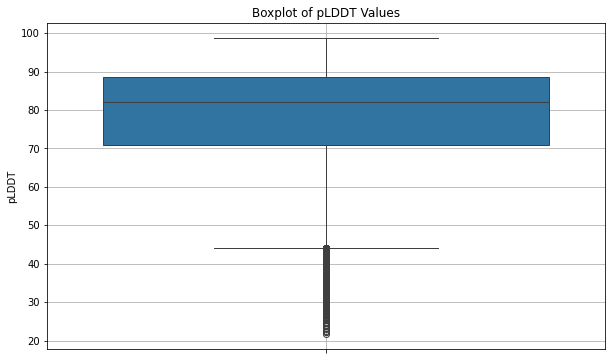

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.chdir('/home/ku76797/Documents/internship/Work/CATHe')

# Load the Train_pLDDT.csv file
df_plddt = pd.read_csv('./data/Dataset/csv/Train_pLDDT.csv')

# Create a boxplot of the pLDDTs
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_plddt['pLDDT'])
plt.title('Boxplot of pLDDT Values')
plt.ylabel('pLDDT')
plt.grid(True)

# Calculate the quartiles
q1 = df_plddt['pLDDT'].quantile(0.25)
q2 = df_plddt['pLDDT'].quantile(0.5)
q3 = df_plddt['pLDDT'].quantile(0.75)

# Print the quartiles
print(f"Q1: {q1}")
print(f"Q2: {q2}")
print(f"Q3: {q3}")

# Calculate the tail limits
lower_tail_limit = q1 - 1.5 * (q3 - q1)
upper_tail_limit = q3 + 1.5 * (q3 - q1)

# Print the tail limits
print(f"Lower Tail Limit: {lower_tail_limit}")
print(f"Upper Tail Limit: {upper_tail_limit}")

# Show the plot
plt.show()


### 3.2 pLDDT filtering tests

In [1]:
import pandas as pd

import os
os.chdir('/home/orfeu/Documents/documents/important/travail/stage/stage/stage_2023_2024/Recherche_scientifique_Londre/Auto_Prot_function_detection_and_classification/work/code/CATHe')

# Read the Train_ids_for_3Di_usage csv files to get the filtered domains for the different pLDDT thresholds
df_train_threshold_0_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_0.csv')
domain_ids_thresh_0_train = df_train_threshold_0_ids['Domain_id']

df_train_thrshold_4_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_4.csv')
domain_ids_thresh_4_train = df_train_thrshold_4_ids['Domain_id']

df_train_threshold_14_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_14.csv')
domain_ids_thresh_14_train = df_train_threshold_14_ids['Domain_id']

df_train_threshold_24_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_24.csv')
domain_ids_thresh_24_train = df_train_threshold_24_ids['Domain_id']

df_train_threshold_34_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_34.csv')
domain_ids_thresh_34_train = df_train_threshold_34_ids['Domain_id']

df_train_threshold_44_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_44.csv')
domain_ids_thresh_44_train = df_train_threshold_44_ids['Domain_id']

df_train_threshold_54_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_54.csv')
domain_ids_thresh_54_train = df_train_threshold_54_ids['Domain_id']

df_train_threshold_64_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_64.csv')
domain_ids_thresh_64_train = df_train_threshold_64_ids['Domain_id']

df_train_threshold_74_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_74.csv')
domain_ids_thresh_74_train = df_train_threshold_74_ids['Domain_id']

df_train_threshold_84_ids = pd.read_csv('./data/Dataset/csv/Train_ids_for_3Di_usage_84.csv')
domain_ids_thresh_84_train = df_train_threshold_84_ids['Domain_id']


df_test_threshold_0_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_0.csv')
domain_ids_thresh_0_test = df_test_threshold_0_ids['Domain_id']

df_test_thrshold_4_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_4.csv')
domain_ids_thresh_4_test = df_test_thrshold_4_ids['Domain_id']

df_test_threshold_14_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_14.csv')
domain_ids_thresh_14_test = df_test_threshold_14_ids['Domain_id']

df_test_threshold_24_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_24.csv')
domain_ids_thresh_24_test = df_test_threshold_24_ids['Domain_id']

df_test_threshold_34_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_34.csv')
domain_ids_thresh_34_test = df_test_threshold_34_ids['Domain_id']

df_test_threshold_44_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_44.csv')
domain_ids_thresh_44_test = df_test_threshold_44_ids['Domain_id']

df_test_threshold_54_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_54.csv')
domain_ids_thresh_54_test = df_test_threshold_54_ids['Domain_id']

df_test_threshold_64_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_64.csv')
domain_ids_thresh_64_test = df_test_threshold_64_ids['Domain_id']

df_test_threshold_74_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_74.csv')
domain_ids_thresh_74_test = df_test_threshold_74_ids['Domain_id']

df_test_threshold_84_ids = pd.read_csv('./data/Dataset/csv/Test_ids_for_3Di_usage_84.csv')
domain_ids_thresh_84_test = df_test_threshold_84_ids['Domain_id']

df_val_threshold_0_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_0.csv')
domain_ids_thresh_0_val = df_val_threshold_0_ids['Domain_id']

df_val_thrshold_4_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_4.csv')
domain_ids_thresh_4_val = df_val_thrshold_4_ids['Domain_id']

df_val_threshold_14_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_14.csv')
domain_ids_thresh_14_val = df_val_threshold_14_ids['Domain_id']

df_val_threshold_24_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_24.csv')
domain_ids_thresh_24_val = df_val_threshold_24_ids['Domain_id']

df_val_threshold_34_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_34.csv')
domain_ids_thresh_34_val = df_val_threshold_34_ids['Domain_id']

df_val_threshold_44_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_44.csv')
domain_ids_thresh_44_val = df_val_threshold_44_ids['Domain_id']

df_val_threshold_54_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_54.csv')
domain_ids_thresh_54_val = df_val_threshold_54_ids['Domain_id']

df_val_threshold_64_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_64.csv')
domain_ids_thresh_64_val = df_val_threshold_64_ids['Domain_id']

df_val_threshold_74_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_74.csv')
domain_ids_thresh_74_val = df_val_threshold_74_ids['Domain_id']

df_val_threshold_84_ids = pd.read_csv('./data/Dataset/csv/Val_ids_for_3Di_usage_84.csv')
domain_ids_thresh_84_val = df_val_threshold_84_ids['Domain_id']

def Number_of_sf_for_threshold(domain_ids, threshold, csv_path, dataset_name):
    # Read the Train.csv file
    df = pd.read_csv(csv_path)
    
    # Filter the dataframe to get the rows where the 'Unnamed: 0' column matches the domain_ids
    filtered_df = df[df['Unnamed: 0'].isin(domain_ids)].drop_duplicates(subset=['SF'])

    print(f"Nb unique SF in {dataset_name} for threshold {threshold}%: {len(filtered_df)}")
    
    # Return the corresponding values in the 'SF' column
    return filtered_df['SF'].tolist()








In [2]:

# Train:
csv_path_train = './data/Dataset/csv/Train.csv'
print("Train:")
sf_thresh_0 = Number_of_sf_for_threshold(domain_ids_thresh_0_train,0, csv_path_train, "Train")
sf_thresh_4 = Number_of_sf_for_threshold(domain_ids_thresh_4_train,4, csv_path_train, "Train")
sf_thresh_14 = Number_of_sf_for_threshold(domain_ids_thresh_14_train,14, csv_path_train, "Train")
sf_thresh_24 = Number_of_sf_for_threshold(domain_ids_thresh_24_train,24, csv_path_train, "Train")
sf_thresh_34 = Number_of_sf_for_threshold(domain_ids_thresh_34_train,34, csv_path_train, "Train")
sf_thresh_44 = Number_of_sf_for_threshold(domain_ids_thresh_44_train,44, csv_path_train, "Train")
sf_thresh_54 = Number_of_sf_for_threshold(domain_ids_thresh_54_train,54, csv_path_train, "Train")
sf_thresh_64 = Number_of_sf_for_threshold(domain_ids_thresh_64_train,64, csv_path_train, "Train")
sf_thresh_74 = Number_of_sf_for_threshold(domain_ids_thresh_74_train,74, csv_path_train, "Train")
sf_thresh_84 = Number_of_sf_for_threshold(domain_ids_thresh_84_train,84, csv_path_train, "Train")



Train:
Nb unique SF in Train for threshold 0%: 1740
Nb unique SF in Train for threshold 4%: 1740
Nb unique SF in Train for threshold 14%: 1740
Nb unique SF in Train for threshold 24%: 1740
Nb unique SF in Train for threshold 34%: 1739
Nb unique SF in Train for threshold 44%: 1739
Nb unique SF in Train for threshold 54%: 1738
Nb unique SF in Train for threshold 64%: 1736
Nb unique SF in Train for threshold 74%: 1718
Nb unique SF in Train for threshold 84%: 1647


In [3]:
# Test:
csv_path_test = './data/Dataset/csv/Test.csv'
print("Test:")
sf_thresh_0 = Number_of_sf_for_threshold(domain_ids_thresh_0_test,0, csv_path_test, "Test")
sf_thresh_4 = Number_of_sf_for_threshold(domain_ids_thresh_4_test,4, csv_path_test, "Test")
sf_thresh_14 = Number_of_sf_for_threshold(domain_ids_thresh_14_test,14, csv_path_test, "Test")
sf_thresh_24 = Number_of_sf_for_threshold(domain_ids_thresh_24_test,24, csv_path_test, "Test")
sf_thresh_34 = Number_of_sf_for_threshold(domain_ids_thresh_34_test,34, csv_path_test, "Test")
sf_thresh_44 = Number_of_sf_for_threshold(domain_ids_thresh_44_test,44, csv_path_test, "Test")
sf_thresh_54 = Number_of_sf_for_threshold(domain_ids_thresh_54_test,54, csv_path_test, "Test")
sf_thresh_64 = Number_of_sf_for_threshold(domain_ids_thresh_64_test,64, csv_path_test, "Test")
sf_thresh_74 = Number_of_sf_for_threshold(domain_ids_thresh_74_test,74, csv_path_test, "Test")
sf_thresh_84 = Number_of_sf_for_threshold(domain_ids_thresh_84_test,84, csv_path_test, "Test")



Test:
Nb unique SF in Test for threshold 0%: 1740
Nb unique SF in Test for threshold 4%: 1740
Nb unique SF in Test for threshold 14%: 1740
Nb unique SF in Test for threshold 24%: 1740
Nb unique SF in Test for threshold 34%: 1739
Nb unique SF in Test for threshold 44%: 1739
Nb unique SF in Test for threshold 54%: 1738
Nb unique SF in Test for threshold 64%: 1736
Nb unique SF in Test for threshold 74%: 1718
Nb unique SF in Test for threshold 84%: 1647


In [4]:
# Val:
csv_path_val = './data/Dataset/csv/Val.csv'
print("Val:")
sf_thresh_0 = Number_of_sf_for_threshold(domain_ids_thresh_0_val,0, csv_path_val, "Val")
sf_thresh_4 = Number_of_sf_for_threshold(domain_ids_thresh_4_val,4, csv_path_val, "Val")
sf_thresh_14 = Number_of_sf_for_threshold(domain_ids_thresh_14_val,14, csv_path_val, "Val")
sf_thresh_24 = Number_of_sf_for_threshold(domain_ids_thresh_24_val,24, csv_path_val, "Val")
sf_thresh_34 = Number_of_sf_for_threshold(domain_ids_thresh_34_val,34, csv_path_val, "Val")
sf_thresh_44 = Number_of_sf_for_threshold(domain_ids_thresh_44_val,44, csv_path_val, "Val")
sf_thresh_54 = Number_of_sf_for_threshold(domain_ids_thresh_54_val,54, csv_path_val, "Val")
sf_thresh_64 = Number_of_sf_for_threshold(domain_ids_thresh_64_val,64, csv_path_val, "Val")
sf_thresh_74 = Number_of_sf_for_threshold(domain_ids_thresh_74_val,74, csv_path_val, "Val")
sf_thresh_84 = Number_of_sf_for_threshold(domain_ids_thresh_84_val,84, csv_path_val, "Val")

Val:
Nb unique SF in Val for threshold 0%: 1740
Nb unique SF in Val for threshold 4%: 1740
Nb unique SF in Val for threshold 14%: 1740
Nb unique SF in Val for threshold 24%: 1740
Nb unique SF in Val for threshold 34%: 1739
Nb unique SF in Val for threshold 44%: 1739
Nb unique SF in Val for threshold 54%: 1738
Nb unique SF in Val for threshold 64%: 1736
Nb unique SF in Val for threshold 74%: 1718
Nb unique SF in Val for threshold 84%: 1647


In [5]:
def check_lost_sf_in_test_or_val(threshold_sf_train, threshold_sf_test, threshold_sf_val, threshold):
    # Identify lost SFs in the Train dataset for the given threshold
    lost_sf_train = set(sf_thresh_0_train).difference(set(threshold_sf_train))
    
    # Check if lost SFs are in the filtered Test or Val dataset for the same threshold
    lost_sf_in_test = lost_sf_train.intersection(set(threshold_sf_test))
    lost_sf_in_val = lost_sf_train.intersection(set(threshold_sf_val))

    print(f"Lost SFs in Train for threshold {threshold}%: {len(lost_sf_train)}")
    print(f"Lost SFs found in Test for threshold {threshold}%: {len(lost_sf_in_test)}")
    print(f"Lost SFs found in Val for threshold {threshold}%: {len(lost_sf_in_val)}")
    return lost_sf_train, lost_sf_in_test, lost_sf_in_val


# Calculate the SFs for Train at threshold 0
csv_path_train = './data/Dataset/csv/Train.csv'
sf_thresh_0_train = Number_of_sf_for_threshold(domain_ids_thresh_0_train, 0, csv_path_train, "Train")

# Calculate the SFs for Test and Val at threshold 0
csv_path_test = './data/Dataset/csv/Test.csv'
sf_thresh_0_test = Number_of_sf_for_threshold(domain_ids_thresh_0_test, 0, csv_path_test, "Test")

csv_path_val = './data/Dataset/csv/Val.csv'
sf_thresh_0_val = Number_of_sf_for_threshold(domain_ids_thresh_0_val, 0, csv_path_val, "Val")

# Check lost SFs for each threshold and whether they are found in filtered Test or Val datasets for that threshold
thresholds = [4, 14, 24, 34, 44, 54, 64, 74, 84]
for threshold, domain_ids_train, domain_ids_test, domain_ids_val in zip(
    thresholds, 
    [domain_ids_thresh_4_train, domain_ids_thresh_14_train, domain_ids_thresh_24_train, 
     domain_ids_thresh_34_train, domain_ids_thresh_44_train, domain_ids_thresh_54_train, 
     domain_ids_thresh_64_train, domain_ids_thresh_74_train, domain_ids_thresh_84_train],
    [domain_ids_thresh_4_test, domain_ids_thresh_14_test, domain_ids_thresh_24_test, 
     domain_ids_thresh_34_test, domain_ids_thresh_44_test, domain_ids_thresh_54_test, 
     domain_ids_thresh_64_test, domain_ids_thresh_74_test, domain_ids_thresh_84_test],
    [domain_ids_thresh_4_val, domain_ids_thresh_14_val, domain_ids_thresh_24_val, 
     domain_ids_thresh_34_val, domain_ids_thresh_44_val, domain_ids_thresh_54_val, 
     domain_ids_thresh_64_val, domain_ids_thresh_74_val, domain_ids_thresh_84_val]):
    
    # Calculate SFs for Train, Test, and Val datasets at the current threshold
    sf_for_threshold_train = Number_of_sf_for_threshold(domain_ids_train, threshold, csv_path_train, f"Train (Threshold {threshold}%)")
    sf_for_threshold_test = Number_of_sf_for_threshold(domain_ids_test, threshold, csv_path_test, f"Test (Threshold {threshold}%)")
    sf_for_threshold_val = Number_of_sf_for_threshold(domain_ids_val, threshold, csv_path_val, f"Val (Threshold {threshold}%)")
    
    # Check lost SFs in Train and their presence in Test and Val for the same threshold
    lost_sf_train, sf_in_test, sf_in_val = check_lost_sf_in_test_or_val(
        sf_for_threshold_train, 
        sf_for_threshold_test, 
        sf_for_threshold_val, 
        threshold
    )


Nb unique SF in Train for threshold 0%: 1740
Nb unique SF in Test for threshold 0%: 1740
Nb unique SF in Val for threshold 0%: 1740
Nb unique SF in Train (Threshold 4%) for threshold 4%: 1740
Nb unique SF in Test (Threshold 4%) for threshold 4%: 1740
Nb unique SF in Val (Threshold 4%) for threshold 4%: 1740
Lost SFs in Train for threshold 4%: 0
Lost SFs found in Test for threshold 4%: 0
Lost SFs found in Val for threshold 4%: 0
Nb unique SF in Train (Threshold 14%) for threshold 14%: 1740
Nb unique SF in Test (Threshold 14%) for threshold 14%: 1740
Nb unique SF in Val (Threshold 14%) for threshold 14%: 1740
Lost SFs in Train for threshold 14%: 0
Lost SFs found in Test for threshold 14%: 0
Lost SFs found in Val for threshold 14%: 0
Nb unique SF in Train (Threshold 24%) for threshold 24%: 1740
Nb unique SF in Test (Threshold 24%) for threshold 24%: 1740
Nb unique SF in Val (Threshold 24%) for threshold 24%: 1740
Lost SFs in Train for threshold 24%: 0
Lost SFs found in Test for threshold 